In [1]:
import os
import re
import time
import math
import glob
import random
from pathlib import Path

import asyncio
from apscheduler.schedulers.asyncio import AsyncIOScheduler
from apscheduler.triggers.interval import IntervalTrigger
from binance import AsyncClient
from binance import Client
from multiprocessing.pool import Pool

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import pandas_ta as ta
from scipy import signal
from distutils.dir_util import copy_tree
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (3.5, 2.5)
import helper_functions
from importlib import reload
helper_functions = reload(helper_functions)

# Download new Data

In [3]:
client = Client()

In [4]:
async_client = await AsyncClient.create()

In [5]:
all_exchange_info = client.get_exchange_info()

all_trading_pairs = {}
all_usdt_pairs = {}
for pair in all_exchange_info['symbols']:
    if pair['status'] == 'TRADING':
        if pair['quoteAsset'] == 'USDT':
            all_usdt_pairs[pair['symbol']] = pair['status']
        all_trading_pairs[pair['symbol']] = pair['status']

In [6]:
len(all_trading_pairs)

1391

In [7]:
len(all_usdt_pairs)

338

In [11]:
endTime = client.get_klines(symbol='BTCUSDT', interval='1d', limit=1, endTime=None)[0][0]
endTime

1677974400000

In [12]:
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime((endTime+0)/1000))

'2023-03-05 01:00:00'

In [28]:
endTime = client.get_klines(symbol='BTCUSDT', interval='1d', limit=1, endTime=None)[0][0] - 1

# coroutine_list = []
# for key in all_usdt_pairs.keys():
#     coroutine_list.append(async_client.get_historical_klines(key, '4h', '10 years ago', end_str=endTime))
    
temp = await async_client.get_historical_klines('DOGEUSDT', '1m', '1 year ago', end_str=endTime)

In [29]:
len(temp)

525328

In [21]:
len(temp)

525343

In [26]:
directory = r'C:\Users\ghost\OneDrive - student.uni-tuebingen.de\Documents\Machine Learning\Binance RL'
new_folder = r'\Data'
new_directory = new_folder + r'\test klines'
Path(directory + new_directory).mkdir(parents=True, exist_ok=True)
# new_directory = new_folder + r'\npy predictions_val'
# Path(directory + new_directory).mkdir(parents=True, exist_ok=True)

In [30]:
np.save(f'Data/test klines/DOGEUSDT.npy', np.asarray(temp, dtype='float'))

In [10]:
all_klines_list = []
n = 10
for _ in range(int(np.ceil(len(all_usdt_pairs)/n))):
    print(f'Step {_+1}/{int(np.ceil(len(all_usdt_pairs)/n))}', end='\r')
    n_klines = await asyncio.gather(*coroutine_list[_*n:(_+1)*n])
    all_klines_list.extend(n_klines)

In [11]:
all_klines = {}
for _, coin in enumerate(list(all_usdt_pairs.keys())):
    all_klines[coin] = all_klines_list[_]

In [12]:
for _, (key, value) in enumerate(all_klines.items()):
    print(f'Step {_+1}/{len(all_klines)}', end='\r')
    klines_array = np.asarray(value, dtype='float')
    np.save(f'Data/all trading klines/{key}.npy', klines_array)

# Indicators

In [76]:
data_input = []
for key, value in data_dict.items():
    data_input.append([key, value])

In [77]:
old_df_dict = {}
if __name__ ==  '__main__':
    pool = Pool()
    # for coin in pool.map(helper_functions.test_f1, data_input):
    for coin in pool.imap_unordered(helper_functions.test_f1, data_input):
        old_df_dict[coin] = coin
        print(f'Coin: {len(old_df_dict)}/{len(data_input)}', end='\r')

# Data

In [85]:
SEQUENCE_LENGTH = 200
USED_LENGTH = 100
VAL_LENGTH = 182*24*60

In [3]:
data_folder = f'test data processed'
label_folder = f'test labels'

In [4]:
data_files = glob.glob(os.path.join('Data/' + data_folder, '*.npy'))
label_files = glob.glob(os.path.join('Data/' + label_folder, '*.npy'))
len(data_files)

2

In [5]:
all_data_length = 0
data_dict = {}
for _, file in enumerate(data_files):
    temp = np.load(file)
    all_data_length += len(temp)
    data_dict[file[len(data_folder)+6:-4]] = temp
all_data_length

1050515

In [6]:
len(data_dict)

2

In [7]:
labels_dict = {}
for _, file in enumerate(label_files):
    temp = np.load(file)
    labels_dict[file[len(label_folder)+6:-4]] = temp

In [8]:
for key, value in data_dict.items():
    print(key, '->', len(value), len(labels_dict[key]))

BTCUSDT -> 525265 525265
DOGEUSDT -> 525250 525250


In [9]:
all_nan_indicators = []
for key, value in data_dict.items():
# for key, value in new_data_processed_dict.items():
    nan_argwhere = np.argwhere(np.isnan(value))
    nan_indicator, nan_length = np.unique(nan_argwhere[:,1], return_counts=True)
    print(key, nan_indicator, nan_length)
    if nan_indicator.shape[0] != 0:
        all_nan_indicators.append(key)

BTCUSDT [] []
DOGEUSDT [] []


In [85]:
all_nan_indicators

[]

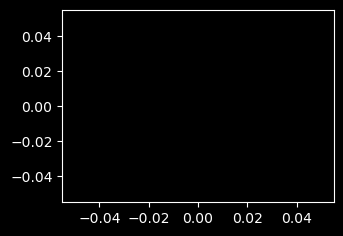

In [86]:
nan_argwhere = np.argwhere(np.isnan(data_dict['BTCUSDT']))
plt.plot(nan_argwhere[:,0], nan_argwhere[:,1], '.')

In [9]:
df = pd.DataFrame(data_dict['DOGEUSDT'][:,[0,1,2,3,4,5,7,8,9,10]], columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume'])
df.set_index(pd.DatetimeIndex(df["Time"]), inplace=True)

In [10]:
df.ta.percent_return(append=True)
label = df.ta.percent_return()

In [11]:
df

,Time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,PCTRET_1
Time,,,,,,,,,,,
1970-01-01 00:27:26.454720,1.646455e+12,0.12220,0.12240,0.12220,0.12240,191930.0,23465.10240,58.0,180337.0,22047.31860,NaN
1970-01-01 00:27:26.454780,1.646455e+12,0.12240,0.12240,0.12230,0.12240,335460.0,41028.88350,30.0,241533.0,29541.61140,0.000000
1970-01-01 00:27:26.454840,1.646455e+12,0.12230,0.12230,0.12200,0.12210,676672.0,82644.20980,108.0,97908.0,11955.97250,-0.002451
1970-01-01 00:27:26.454900,1.646455e+12,0.12210,0.12210,0.12180,0.12190,1106851.0,134898.50240,129.0,219364.0,26721.21360,-0.001638
1970-01-01 00:27:26.454960,1.646455e+12,0.12190,0.12190,0.12180,0.12190,195666.0,23843.23450,41.0,186255.0,22696.56250,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:27:57.974100,1.677974e+12,0.07454,0.07457,0.07454,0.07457,46849.0,3492.54027,31.0,31704.0,2363.58274,0.000268
1970-01-01 00:27:57.974160,1.677974e+12,0.07457,0.07459,0.07457,0.07459,103355.0,7708.35496,48.0,89180.0,6651.26691,0.000268
1970-01-01 00:27:57.974220,1.677974e+12,0.07459,0.07462,0.07459,0.07462,99199.0,7400.80915,52.0,88262.0,6584.90371,0.000402


In [12]:
df.ta.cores = 8
df.ta.strategy(ta.AllStrategy, timed=True, verbose=True)
excluded_list = ['Time', 'DPO_20', 'EOM_14_100000000', 'ICS_26', 'SQZ_NO', 'SQZPRO_NO',
                 'SUPERTl_7_3.0', 'SUPERTs_7_3.0', 'QQEl_14_5_4.236', 'QQEs_14_5_4.236',
                'PSARl_0.02_0.2', 'PSARs_0.02_0.2', 'HILOl_13_21', 'HILOs_13_21',
                'BBL_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0']
df = df.drop(excluded_list, axis=1)

[+] Strategy: All
[i] Indicator arguments: {'timed': True, 'append': True}
[i] Excluded[12]: above, above_value, below, below_value, cross, cross_value, long_run, short_run, td_seq, tsignals, vp, xsignals
[i] Multiprocessing 131 indicators with 3 chunks and 8/8 cpus.


131it [04:28,  2.05s/it]


[i] Total indicators: 131
[i] Columns added: 217
[i] Last Run: Sunday March 5, 2023, NYSE: 3:54:42, Local: 7:54:42 W. Europe Standard Time, Day 64/365 (18.00%)
[i] Runtime: 268426.5273 ms (268.4265 s)


In [13]:
df

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,PCTRET_1,...,VIDYA_14,VTXP_14,VTXM_14,VWAP_D,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
Time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:27:26.454720,0.12220,0.12240,0.12220,0.12240,191930.0,23465.10240,58.0,180337.0,22047.31860,NaN,...,NaN,NaN,NaN,0.122333,NaN,0.122350,NaN,NaN,NaN,NaN
1970-01-01 00:27:26.454780,0.12240,0.12240,0.12230,0.12240,335460.0,41028.88350,30.0,241533.0,29541.61140,0.000000,...,NaN,NaN,NaN,0.122355,NaN,0.122375,NaN,NaN,NaN,NaN
1970-01-01 00:27:26.454840,0.12230,0.12230,0.12200,0.12210,676672.0,82644.20980,108.0,97908.0,11955.97250,-0.002451,...,NaN,NaN,NaN,0.122230,NaN,0.122125,NaN,NaN,NaN,NaN
1970-01-01 00:27:26.454900,0.12210,0.12210,0.12180,0.12190,1106851.0,134898.50240,129.0,219364.0,26721.21360,-0.001638,...,NaN,NaN,NaN,0.122088,NaN,0.121925,NaN,NaN,NaN,NaN
1970-01-01 00:27:26.454960,0.12190,0.12190,0.12180,0.12190,195666.0,23843.23450,41.0,186255.0,22696.56250,0.000000,...,NaN,NaN,NaN,0.122071,NaN,0.121875,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:27:57.974100,0.07454,0.07457,0.07454,0.07457,46849.0,3492.54027,31.0,31704.0,2363.58274,0.000268,...,NaN,1.272727,0.690909,0.096924,0.074506,0.074563,0.000000,0.074524,0.074562,1.342153
1970-01-01 00:27:57.974160,0.07457,0.07459,0.07457,0.07459,103355.0,7708.35496,48.0,89180.0,6651.26691,0.000268,...,NaN,1.346154,0.634615,0.096924,0.074513,0.074585,0.000000,0.074540,0.074583,1.403778
1970-01-01 00:27:57.974220,0.07459,0.07462,0.07459,0.07462,99199.0,7400.80915,52.0,88262.0,6584.90371,0.000402,...,NaN,1.277778,0.611111,0.096924,0.074521,0.074612,0.000000,0.074559,0.074599,1.544788


In [14]:
nan_place_list = np.argwhere(np.isnan(df.values[77:]))
nan_index_list = np.unique(nan_place_list[:,1])
nan_index_list

array([ 47,  48,  58,  69, 196, 200], dtype=int64)

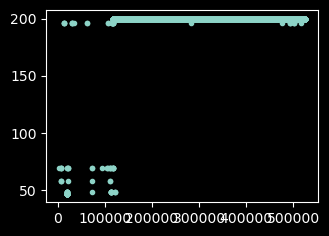

In [15]:
plt.plot(nan_place_list[:,0], nan_place_list[:,1], '.')

In [40]:
df.columns[nan_index_list]

Index(['high_Z_30_1', 'low_Z_30_1', 'CTI_12', 'ER_10', 'UI_14', 'VIDYA_14'], dtype='object')

In [87]:
def preprocess_data(s, return_values=False, loaded_values=None):
    new = np.copy(s)
    values = []
    for _ in range(new.shape[1]):
        temp = new[:,_]
        if loaded_values is None:
            std1 = np.std(temp)
        else:
            std1 = loaded_values[_, 0]
        if std1 > 1000:
            temp *= 1000 / std1
        if std1 < 10:
            temp *= 10 / std1
        temp = np.arcsinh(temp)
        if loaded_values is None:
            std2 = np.std(temp)
            mean2 = np.mean(temp)
        else:
            std2 = loaded_values[_, 1]
            mean2 = loaded_values[_, 2]
        new[:,_] = (temp - mean2) / std2 / 2
        if return_values==True:
            values.append([std1, std2, mean2])
    if return_values==True:
        return np.array(values)
    else:
        return new

In [88]:
for _, (key, value) in enumerate(data_dict.items()):
    print(f'Coin: {_+1}/{len(data_dict)}', end='\r')
    temp_values = preprocess_data(value, return_values=True)
    np.save(f'Data/test data constants/{key}.npy', temp_values)

In [89]:
np.load(f'Data/test data constants/BTCUSDT.npy').shape

(204, 3)

In [90]:
np.argwhere(np.isnan(np.load(f'Data/test data constants/BTCUSDT.npy')[:]))

array([], shape=(0, 2), dtype=int64)

In [103]:
new_data_processed_dict = {}
for _, (key, value) in enumerate(data_dict.items()):
    print(f'Coin: {_+1}/{len(data_dict)}', end='\r')
    temp_values = np.load(f'Data/test data constants/{key}.npy')
    new_data_processed_dict[key] = preprocess_data(value, loaded_values=temp_values)[:-1]
    np.save(f'Data/test data processed/{key}.npy', new_data_processed_dict[key])

In [104]:
filtered_data_dict = {}
for key, value in new_data_processed_dict.items():
    nan_array = np.argwhere(np.isnan(value))
    if nan_array.size == 0:
        filtered_data_dict[key] = value
        print(np.argwhere(np.isnan(filtered_data_dict[key])), key)
    # print(np.argwhere(np.isnan(value)), key)

[] BTCUSDT
[] DOGEUSDT


In [94]:
for _, (key, value) in enumerate(data_dict.items()):
    print(f'Step {_+1}/{len(data_dict)}', end='\r')
    percent = 100*value[1:,9]
    np.save(f'Data/test labels/{key}.npy', np.expand_dims(percent, axis=1))

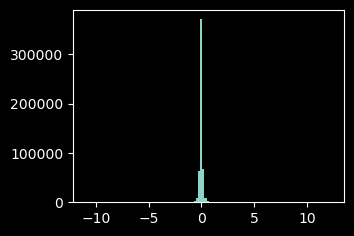

In [97]:
plt.hist(np.load(f'Data/test labels/DOGEUSDT.npy'), bins=120)
plt.show()

# Training

In [8]:
def calculate_rewards(balance):
    rewards = []
    rewards.append(100*(balance[-1]-1))
    for b in balance:
        rewards.append(100*(balance[-1]-b)/b)
    return np.array(rewards[:-2])

In [83]:
def performance(predictions, true_prices, fee=0, epsilon=0, threshold=0, short=False, traded_balance=False, training=False):
    balance, trade_balance = [], []
    trade_lengths = []
    trade_performances = []
    acted_predictions = []
    action_indeces = []
    rewards = []
    current_balance = 1.
    position = 0
    start = False
    min_trade_length = -1
    for _, (p1, p2) in enumerate(zip(predictions, true_prices)):
        if short==True:
            condition = p1 < threshold
            if condition==False:
                start = True
        if short==False:
            condition = p1 > threshold
            if condition==False:
                start = True
        if start:
            if condition or min_trade_length > 0:
                if position == 0:
                    if epsilon > 0:
                        e = np.random.random()
                        if e < epsilon:
                            min_trade_length = 9 + np.ceil(31*np.random.random())
                    temp_trade_balance = []
                    temp_action_indeces = []
                    temp_acted_prediction = []
                    if training:
                        current_balance = 1.
                    current_balance *= (1-fee)
                    position = np.sign(p1)
                min_trade_length -= 1
                current_balance *= 1.+(position*p2/100)
                temp_trade_balance.append(current_balance)
                temp_acted_prediction.append(p1)
                temp_action_indeces.append(_)
            else:
                if position != 0:
                    position = 0
                    current_balance *= (1-fee)
                    temp_trade_balance.append(current_balance)
                    action_indeces.extend(temp_action_indeces)
                    acted_predictions.extend(temp_acted_prediction)
                    trade_balance.extend(temp_trade_balance)
                    trade_lengths.append(len(temp_trade_balance))
                    trade_performances.append(100*(current_balance-1))
                    if training:
                        rewards.extend(calculate_rewards(temp_trade_balance))
        balance.append(current_balance)
    if traded_balance:
        return trade_balance
    elif training:
        return trade_lengths, trade_performances, acted_predictions, action_indeces, rewards
    else:
        return balance

In [10]:
HEADS = 8
LAYERS = 1
FC = 1024
D_MODEL = 256
DROPOUT = 0.1

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [12]:
class Model(nn.Module):
    def __init__(self, device=device):
        super(Model, self).__init__()
        self.pos_enc = torch.unsqueeze(torch.tensor(np.linspace(-1, 1, num=SEQUENCE_LENGTH), dtype=torch.float32, device=device), 1)
        self.src_mask = (torch.triu(torch.ones((SEQUENCE_LENGTH, SEQUENCE_LENGTH), device=device)) == 1).transpose(0, 1).float()
        self.src_mask = self.src_mask.masked_fill(self.src_mask == 0, float('-inf'))
        self.src_mask = self.src_mask.masked_fill(self.src_mask == 1, float(0.0))
        # self.input_length = data_processed_list[0].shape[1] + 1
        self.input_length = 205
        self.embed_dim = D_MODEL
        
        self.layers = nn.ModuleDict()
        self.layers[f'e'] = nn.Linear(self.input_length, self.embed_dim).to(device)
        for i in range(LAYERS):
            self.layers[f'l{i}'] = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=HEADS, dim_feedforward=FC, dropout=DROPOUT, batch_first=True, norm_first=True).to(device)
        self.layers[f'p'] = nn.Linear(self.embed_dim, 1).to(device)


    def forward(self, s, device=device):
        if type(s).__module__ == np.__name__:
            s = torch.tensor(s, dtype=torch.float, device=device)
        pos_enc = self.pos_enc[:s.size()[s.dim()-2]]
        if s.dim() == 3:
            pos_enc = pos_enc.repeat(s.size()[0], 1, 1)
        out = torch.cat((s, pos_enc), s.dim()-1)
        out = self.layers[f'e'](out)
        for i in range(LAYERS):
            out = self.layers[f'l{i}'](out, self.src_mask[:s.size()[s.dim()-2],:s.size()[s.dim()-2]])
        out = self.layers[f'p'](out)
        return out

In [113]:
model = Model()
model.eval()
parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
MAX_BATCH = int(628395*600*200**2/(parameters*SEQUENCE_LENGTH**2))
print(f'Number of parameters: {parameters}')
print(f'Max Batch: {MAX_BATCH*0.8}')

Number of parameters: 842753
Max Batch: 357.6


In [114]:
lr_finder = False
MAX_BATCH = int(628395*600*200/(sum(p.numel() for p in model.parameters() if p.requires_grad)*SEQUENCE_LENGTH))
BATCH_SIZE = 50
BATCH_MULTIPLYER = 1
epoch_length = math.ceil(1*all_data_length/(USED_LENGTH*BATCH_SIZE*BATCH_MULTIPLYER))
mse_loss = nn.MSELoss()

writer = SummaryWriter()
# cd 'C:\Users\ghost\OneDrive - student.uni-tuebingen.de\Documents\Machine Learning\Binance RL'
# tensorboard --logdir=runs
lrs = []
mses = []
prediction_losses = []
last_best_epoch, last_best_step = 0, 0
last_checkpoint_step, last_save_step = 0, 0
checkpoint_counter, save_counter = 0, 0
mse_min = 100
old_length = 0

if lr_finder == True:
    # steps = 10
    steps = min(10000, max(600, epoch_length))
    optimizer = torch.optim.RAdam(model.parameters(), lr=1e-8)
else:
    steps = 10000
    # steps = 10*epoch_length
    optimizer = torch.optim.RAdam(model.parameters(), lr=1e-5)
    # optimizer = torch.optim.RAdam(model.parameters(), lr=lr_opt)

In [116]:
optimizer = torch.optim.RAdam(model.parameters(), lr=3e-6)

In [117]:
BATCH_SIZE = 150

In [118]:
if lr_finder == True:
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1e6**(1/steps))
model.train()

for _ in range(steps):
    temp_loss = 0
    temp_performances_mean, temp_performances_std = 0, 0
    temp_lengths_mean, temp_lengths_std = 0, 0
    temp_prediction_mean, temp_prediction_std = 0, 0
    temp_trading_time = 0
    for i2 in range(BATCH_MULTIPLYER):
        temp_data, temp_label = [], []
        for i in range(BATCH_SIZE):
            key = random.choices(list(data_dict), k=1)
            n2 = np.random.randint(len(data_dict[key[0]])-VAL_LENGTH-SEQUENCE_LENGTH)
            
            temp1 = torch.tensor(data_dict[key[0]][:-VAL_LENGTH][n2:n2+SEQUENCE_LENGTH], dtype=torch.float, device=device)
            temp2 = labels_dict[key[0]][:-VAL_LENGTH][n2:n2+SEQUENCE_LENGTH][-USED_LENGTH:]
            temp_data.append(temp1)
            temp_label.append(temp2)

        temp_data = torch.stack(temp_data)
        prediction = model(temp_data)[:,-USED_LENGTH:,:]
        temp_prediction = prediction.cpu().detach().numpy()
        
        trade_lengths, trade_performances, acted_predictions, action_indeces, rewards = [], [], [], [], []
        for i in range(BATCH_SIZE):
            _1, _2, _3, _4, _5 = performance(temp_prediction[i].flatten(), temp_label[i].flatten(), epsilon=0.05, training=True)
            trade_lengths.extend(_1)
            trade_performances.extend(_2)
            acted_predictions.extend(_3)
            action_indeces.extend(_4)
            rewards.extend(_5)
        
        prediction = torch.flatten(prediction, end_dim=1)[action_indeces]
        rewards = np.expand_dims(rewards, axis=1)
        rewards = torch.tensor(rewards, dtype=torch.float, device=device)
        prediction_loss = mse_loss(prediction, rewards) / BATCH_MULTIPLYER
        prediction_loss.backward()
        
        temp_loss += prediction_loss.detach().cpu().numpy()
        temp_performances_mean += np.mean(trade_performances) / BATCH_MULTIPLYER
        temp_performances_std += np.std(trade_performances) / BATCH_MULTIPLYER
        temp_lengths_mean += np.mean(trade_lengths) / BATCH_MULTIPLYER
        temp_lengths_std += np.std(trade_lengths) / BATCH_MULTIPLYER
        temp_prediction_mean += np.mean(acted_predictions) / BATCH_MULTIPLYER
        temp_prediction_std += np.std(acted_predictions) / BATCH_MULTIPLYER
        temp_trading_time += len(action_indeces)/len(temp_label) / BATCH_MULTIPLYER
        
    optimizer.step()
    optimizer.zero_grad()    
    
    writer.add_scalar("Value Loss/train", temp_loss, _+1+old_length)
    writer.add_scalar("Performance Mean/train", temp_performances_mean, _+1+old_length)
    writer.add_scalar("Performance Std/train", temp_performances_std, _+1+old_length)
    writer.add_scalar("Prediction Mean/train", temp_prediction_mean, _+1+old_length)
    writer.add_scalar("Prediction Std/train", temp_prediction_std, _+1+old_length)
    writer.add_scalar("Trading Length Mean/train", temp_lengths_mean, _+1+old_length)
    writer.add_scalar("Trading Length Std/train", temp_lengths_std, _+1+old_length)
    writer.add_scalar("Time spent trading/train", temp_trading_time, _+1+old_length)
    prediction_losses.append(temp_loss)
    
    with torch.no_grad():
        model.eval()
        temp_loss = 0
        temp_performances_mean, temp_performances_std = 0, 0
        temp_lengths_mean, temp_lengths_std = 0, 0
        temp_prediction_mean, temp_prediction_std = 0, 0
        temp_trading_time = 0
        for i2 in range(BATCH_MULTIPLYER):
            temp_data, temp_label = [], []
            for i in range(BATCH_SIZE):
                key = random.choices(list(data_dict), k=1)
                n2 = np.random.randint(VAL_LENGTH-SEQUENCE_LENGTH)

                temp1 = torch.tensor(data_dict[key[0]][-VAL_LENGTH:][n2:n2+SEQUENCE_LENGTH], dtype=torch.float, device=device)
                temp2 = labels_dict[key[0]][-VAL_LENGTH:][n2:n2+SEQUENCE_LENGTH][-USED_LENGTH:]
                temp_data.append(temp1)
                temp_label.append(temp2)
                
            temp_data = torch.stack(temp_data)
            prediction = model(temp_data)[:,-USED_LENGTH:,:]
            temp_prediction = prediction.cpu().detach().numpy()

            trade_lengths, trade_performances, acted_predictions, action_indeces, rewards = [], [], [], [], []
            for i in range(BATCH_SIZE):
                _1, _2, _3, _4, _5 = performance(temp_prediction[i].flatten(), temp_label[i].flatten(), training=True)
                trade_lengths.extend(_1)
                trade_performances.extend(_2)
                acted_predictions.extend(_3)
                action_indeces.extend(_4)
                rewards.extend(_5)
                    
            prediction = torch.flatten(prediction, end_dim=1)[action_indeces]
            rewards = np.expand_dims(rewards, axis=1)
            rewards = torch.tensor(rewards, dtype=torch.float, device=device)
            prediction_loss = mse_loss(prediction, rewards) / BATCH_MULTIPLYER

            temp_loss += prediction_loss.detach().cpu().numpy()
            temp_performances_mean += np.mean(trade_performances) / BATCH_MULTIPLYER
            temp_performances_std += np.std(trade_performances) / BATCH_MULTIPLYER
            temp_lengths_mean += np.mean(trade_lengths) / BATCH_MULTIPLYER
            temp_lengths_std += np.std(trade_lengths) / BATCH_MULTIPLYER
            temp_prediction_mean += np.mean(acted_predictions) / BATCH_MULTIPLYER
            temp_prediction_std += np.std(acted_predictions) / BATCH_MULTIPLYER
            temp_trading_time += len(action_indeces)/len(temp_label) / BATCH_MULTIPLYER
        
        writer.add_scalar("Value Loss/val", temp_loss, _+1+old_length)
        writer.add_scalar("Performance Mean/val", temp_performances_mean, _+1+old_length)
        writer.add_scalar("Performance Std/val", temp_performances_std, _+1+old_length)
        writer.add_scalar("Prediction Mean/val", temp_prediction_mean, _+1+old_length)
        writer.add_scalar("Prediction Std/val", temp_prediction_std, _+1+old_length)
        writer.add_scalar("Trading Length Mean/val", temp_lengths_mean, _+1+old_length)
        writer.add_scalar("Trading Length Std/val", temp_lengths_std, _+1+old_length)
        writer.add_scalar("Time spent trading/val", temp_trading_time, _+1+old_length)
        mses.append(temp_loss)
        
        kernel_size = math.ceil(len(prediction_losses)*0.2)
        if _ % math.ceil(kernel_size/9) == 0:
            checkpoint_counter += 1
            last_checkpoint_step = _+old_length
            torch.save(model.state_dict(), f'Models/checkpoints/checkpoint-{checkpoint_counter % 9}')
        if _ > int(0.5*epoch_length):
            mse_temp = signal.convolve(mses[-kernel_size:], np.ones(kernel_size)/kernel_size, mode='valid')
            if mse_temp[-1] < mse_min:
                mse_min = mse_temp[-1]
                last_best_step = round(_+1+old_length - kernel_size/2)
                last_best_epoch = round(last_best_step/epoch_length, 1)
                if last_save_step != last_checkpoint_step:
                    last_save_step = last_checkpoint_step
                    save_counter = checkpoint_counter
                    copy_tree('Models/checkpoints', f'Models/trained_ensemble')
        # if (len(prediction_losses) - last_best_step) > max(0.4*len(prediction_losses), 20*epoch_length) and lr_finder == False:
        #     break
        model.train()

    if lr_finder == True:
        lrs.append(scheduler.get_last_lr())
        scheduler.step()
    print(f'Step: {_+1}    Epoch: {round((_+1)/epoch_length, 1)}    min MSE: {round(mse_min, 3)}   at Epoch: {last_best_epoch}   at Step: {last_best_step}   Model-No: {(save_counter-4) % 9}   ', end='\r')
model.eval()
old_length += steps

KeyboardInterrupt: 

In [82]:
steps = 4000

In [81]:
old_length

14000

In [33]:
old_length += 3016

In [20]:
model.load_state_dict(torch.load('Models/checkpoints/checkpoint-3'))

<All keys matched successfully>

Learning Rate: 4.8977881936844046e-05
Learning Rate: 0.0001949844599758017
Learning Rate: 0.0007585775750291712
Learning Rate chosen: 0.0007585775750291712


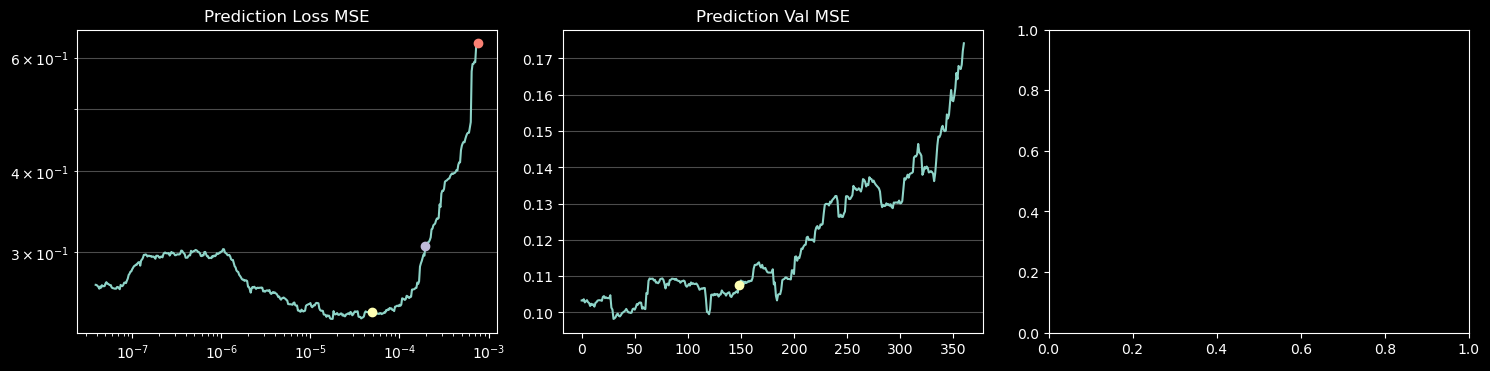

In [105]:
kernel_size = int(len(prediction_losses)*0.2)
# kernel_size = 2

if lr_finder == True:
    lrss = lrs[int(np.floor(kernel_size/2))-1:-int(np.ceil(kernel_size/2))]
prediction_losses_avg = np.array(prediction_losses)
prediction_losses_avg = signal.convolve(prediction_losses_avg, np.ones(kernel_size)/kernel_size, mode='valid')
prediction_losses_gradient_avg = np.gradient(prediction_losses_avg)
prediction_losses_gradient_avg = signal.convolve(prediction_losses_gradient_avg, np.ones(kernel_size)/kernel_size, mode='valid')
idx_min = np.argmin(prediction_losses_gradient_avg)

plot_mse = signal.convolve(mses, np.ones(kernel_size)/kernel_size, mode='valid')

plt.figure(figsize=(15,7))
plt.subplot(2, 3, 1).title.set_text(f'Prediction Loss MSE')
if lr_finder == True:
    plt.plot(lrss, prediction_losses_avg)
    plt.plot(lrss[idx_min], prediction_losses_avg[idx_min], 'o')
    plt.plot(lrss[idx_min+int(kernel_size/2)], prediction_losses_avg[idx_min+int(kernel_size/2)], 'o')
    plt.plot(lrss[idx_min+kernel_size-1], prediction_losses_avg[idx_min+kernel_size-1], 'o')
    plt.semilogx()
    lr_opt = lrss[idx_min+kernel_size-1][0]
    # lr_opt = lrss[idx_min+int(kernel_size/2)][0]
    print(f'Learning Rate: {lrss[idx_min][0]}')
    print(f'Learning Rate: {lrss[idx_min+int(kernel_size/2)][0]}')
    print(f'Learning Rate: {lrss[idx_min+kernel_size-1][0]}')
    print(f'Learning Rate chosen: {lr_opt}')
else:
    plt.plot(prediction_losses_avg)
    print(f'last loss: {round(prediction_losses_avg[-1], 3)}')
    print(f'Min MAE: {round(mse_min, 3)}, at Step: {round(last_best_step-kernel_size/2)}')
    print(f'Plot min MAE: {round(min(plot_mse), 3)}, at Step: {np.argmin(plot_mse)}')
plt.semilogy()
plt.grid(which='both', axis='y', alpha=0.3)

plt.subplot(2, 3, 2).title.set_text(f'Prediction Val MSE')
if lr_finder == True:
    plt.plot(plot_mse)
    plt.plot(last_best_step-kernel_size/2, plot_mse[round(last_best_step-kernel_size/2)], 'o')
else:
    plt.plot(plot_mse[:])
    plt.plot(last_best_step-kernel_size/2, plot_mse[:][round(last_best_step-kernel_size/2)], 'o')
plt.grid(which='both', axis='y', alpha=0.3)

plt.subplot(2, 3, 3)

plt.tight_layout()
plt.show()

Learning Rate: 0.0028840315031265517
Learning Rate: 0.00295120922666633
Learning Rate: 0.00295120922666633
Learning Rate chosen: 0.00295120922666633


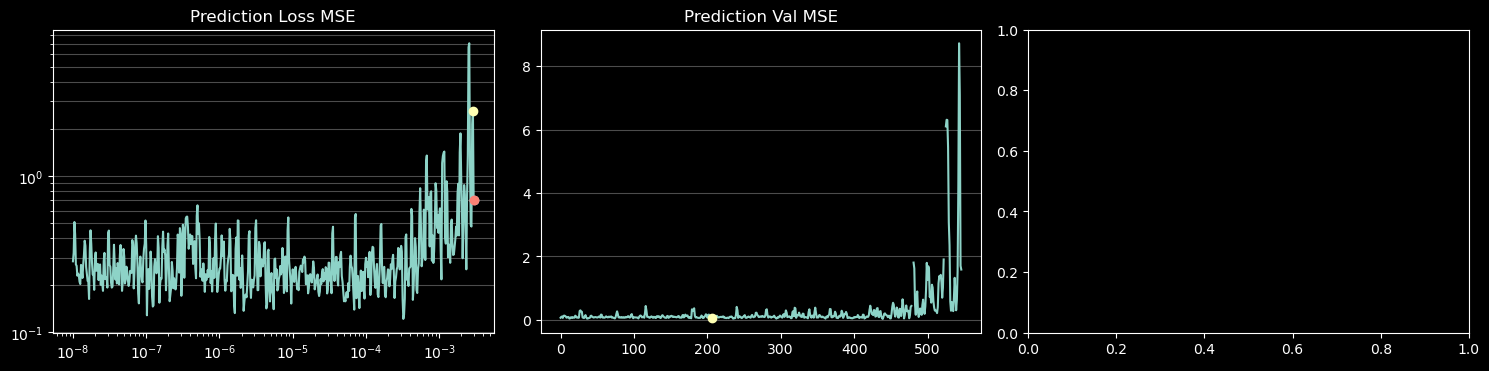

In [106]:
# kernel_size = int(len(prediction_losses)*0.2)
kernel_size = 2
if lr_finder == True:
    lrss = lrs[int(np.floor(kernel_size/2))-1:-int(np.ceil(kernel_size/2))]
prediction_losses_avg = np.array(prediction_losses)
prediction_losses_avg = signal.convolve(prediction_losses_avg, np.ones(kernel_size)/kernel_size, mode='valid')
prediction_losses_gradient_avg = np.gradient(prediction_losses_avg)
prediction_losses_gradient_avg = signal.convolve(prediction_losses_gradient_avg, np.ones(kernel_size)/kernel_size, mode='valid')
idx_min = np.argmin(prediction_losses_gradient_avg)

plot_mse = signal.convolve(mses, np.ones(kernel_size)/kernel_size, mode='valid')

plt.figure(figsize=(15,7))
plt.subplot(2, 3, 1).title.set_text(f'Prediction Loss MSE')
if lr_finder == True:
    plt.plot(lrss, prediction_losses_avg)
    plt.plot(lrss[idx_min], prediction_losses_avg[idx_min], 'o')
    plt.plot(lrss[idx_min+int(kernel_size/2)], prediction_losses_avg[idx_min+int(kernel_size/2)], 'o')
    plt.plot(lrss[idx_min+kernel_size-1], prediction_losses_avg[idx_min+kernel_size-1], 'o')
    plt.semilogx()
    lr_opt = lrss[idx_min+kernel_size-1][0]
    # lr_opt = lrss[idx_min+int(kernel_size/2)][0]
    print(f'Learning Rate: {lrss[idx_min][0]}')
    print(f'Learning Rate: {lrss[idx_min+int(kernel_size/2)][0]}')
    print(f'Learning Rate: {lrss[idx_min+kernel_size-1][0]}')
    print(f'Learning Rate chosen: {lr_opt}')
else:
    plt.plot(prediction_losses_avg)
    print(f'last loss: {round(prediction_losses_avg[-1], 3)}')
    print(f'Min MAE: {round(mse_min, 3)}, at Step: {round(last_best_step-kernel_size/2)}')
    print(f'Plot min MAE: {round(min(plot_mse), 3)}, at Step: {np.argmin(plot_mse)}')
plt.semilogy()
plt.grid(which='both', axis='y', alpha=0.3)

plt.subplot(2, 3, 2).title.set_text(f'Prediction Val MSE')
if lr_finder == True:
    plt.plot(plot_mse)
    plt.plot(last_best_step-kernel_size/2, plot_mse[round(last_best_step-kernel_size/2)], 'o')
else:
    plt.plot(plot_mse[:])
    plt.plot(last_best_step-kernel_size/2, plot_mse[:][round(last_best_step-kernel_size/2)], 'o')
plt.grid(which='both', axis='y', alpha=0.3)

plt.subplot(2, 3, 3)

plt.tight_layout()
plt.show()